<div style="text-align: right">
**Final Project**<br>
Time-to-event analysis of linguisic data<br>
Instructor: Peter Hendrix<br>
Winter Semester 2019/20<br>
University of Tübingen
</div>

# Time-to-event analysis of past tense generation data
The present project is a demonstration of time-to-event analysis of past tense verb inflection data. It aims at exploring how qualitative features like e.g. regularity or word length of a target verb influence the time needed for producing the past tense form of the verb during a linguistic experiment.

#### Preparing the notebook environment
This will install the package that includes the dataset and load all the libraries necessary for TTE analysis.

In [1]:
# installing packages and loading libraries

library(devtools)
install.packages("ggsignif")
install_github("PeterHendrix13/TTEdata")

library(survival)
library(survminer)
library(multcomp)
library(TTEdata)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




✔  checking for file ‘/tmp/RtmprzYjbn/remotesb6ae277b4/PeterHendrix13-TTEdata-705fdb2/DESCRIPTION’
─  preparing ‘TTEdata’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
     NB: this package now depends on R (>= 3.5.0)
─  building 'TTEdata_1.0.tar.gz'
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: magrittr

Loading required package: mvtnorm

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




## 1. The past tense generation dataset
The database of response latencies for past tense verb inflection that is used in the present project comes from the Past Tense Inflection Project (PTIP) by Cohen-Shikora et al. (2013). Participants of the PTIP were asked to produce the past tense of verbs that were shown to them in the present tense form and their response times were measured.
The dataset contains records of the average response time for a total of 1978 verbs. Besides the response time, the following information about each verb are included: 
* **regularity:** regular or irregular past tense conjugation
* **log.frequency:** log-transformed frequency count
* **length:** word length in letters
* **log.old20:** log-transformed orthographic similarity of the word to other words
* **snd:** semantic similarity of the word to other words

In [2]:
# inspect data
head(vb)
dim(vb)

,word,rt,regularity,log.frequency,length,log.old20,snd
,<chr>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
1,engrave,704.5333,regular,2.708050,7,0.8960880,0.7657519
2,complement,729.7000,regular,3.663562,10,0.9360934,0.5911747
3,sleep,701.5833,irregular,9.360913,5,0.4054651,0.6988538
4,lag,705.4483,regular,4.317488,3,0.0000000,0.4365067
5,sense,712.0345,regular,8.813141,5,0.5306283,0.6267723
6,extradite,900.4074,regular,2.564949,9,1.2527630,0.7547978


[1] 1978    7

### 1.1 Regularity
Of the 1978 verbs in the dataset, 1824 are regular. They represent 92.2 percent of the data. The 154 irregular verbs make up the remaining 7.8 percent.

In [3]:
# number of regular verbs
nrow(vb[which(vb$regularity == 'regular'),])
# percentage of regular verbs
nrow(vb[which(vb$regularity == 'regular'),]) / nrow(vb)*100

# number of irregular verbs
nrow(vb[which(vb$regularity == 'irregular'),])
# percentage of irregular verbs
nrow(vb[which(vb$regularity == 'irregular'),]) / nrow(vb)*100

[1] 1824

[1] 92.21436

[1] 154

[1] 7.785642

### 1.2 Word length distribution
We can have a look at the distribution of word lengths by visualising it in a bar plot:

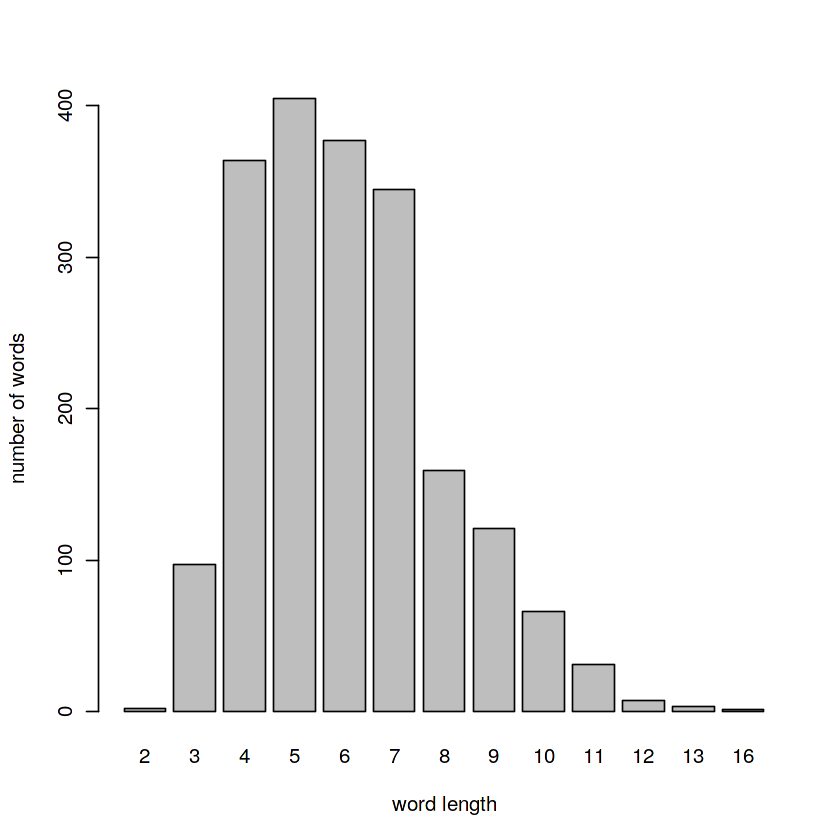

In [4]:
# make table of word lengths
tab = table(vb$length)
# barplot of word lengths
barplot(tab, xlab = "word length", ylab = "number of words")

As can be seen in the barplot, word length ranges from 2 to 16 letters. Most words, namely 405, have a length of 5. The 11 verbs that are 12 or more letters long are all regular. The two shortest verbs in the dataset, *go* and *do*, are both irregular and have very high frequencies. The average length of a verb in the data is 6 letters.

In [5]:
# number of words with length 5
sum(vb$length==5)
# inspect words with length equal to or longer than 12
vb[which(vb$length >= 12),]
# inspect words with length 2
vb[which(vb$length==min(vb$length)),]
# mean length
mean(vb$length)

[1] 405

,word,rt,regularity,log.frequency,length,log.old20,snd
,<chr>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
111,compartmentalize,933.5185,regular,2.397895,16,1.916923,0.7069433
559,overestimate,744.9333,regular,3.135494,12,1.423108,0.8948338
812,individualize,697.5926,regular,1.386294,13,1.578979,0.6571378
877,substantiate,797.5000,regular,2.995732,12,1.335001,0.8343165
1040,discriminate,718.9286,regular,3.713572,12,1.335001,0.7772080
1296,redistribute,793.9600,regular,2.079442,12,1.504077,0.6059132
1368,differentiate,809.8846,regular,2.833213,13,1.504077,0.7532341
1527,counterattack,907.6296,regular,3.688879,13,1.589235,0.8232366
1723,disintegrate,800.1481,regular,3.258097,12,1.360977,0.8354112


,word,rt,regularity,log.frequency,length,log.old20,snd
,<chr>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
1057,go,1040.7414,irregular,12.17275,2,0,0.6552651
1089,do,945.0167,irregular,12.65369,2,0,0.5854840


[1] 6.043478

### 1.3 Response time distribution
The distribution of response times can be visualised with a density plot. The probability density function generates estimates of the relative likelihood of a response event at each millisecond. 

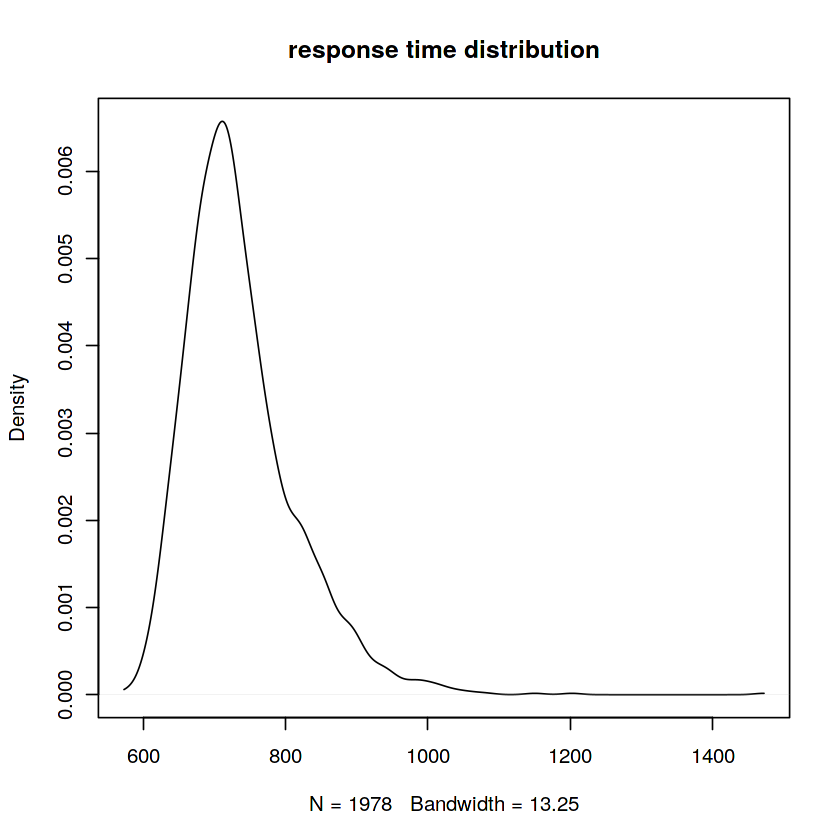

In [6]:
# round rt
vb$rt = round(vb$rt)

# generate probability density estimates at each ms
min.time = min(vb$rt)
max.time = max(vb$rt)
d = density(vb$rt, from = min.time, to = max.time, n = length(min.time:max.time))

# density plot
plot(d, main = "response time distribution")

The response time distribution curve shows the typical shape of a normal distribution. The responses start coming in just before 600 ms after stimulus onset and most of them occur within 1000 ms after stimulus onset. After that, the probability density curve asymptotically approaches 0. <br>
The probabilty density function reaches its maximum at 711 ms after stimulus onset. This means that it is more likely that a participant responds at 711 ms than at any of the other time points. We can also compare the relative likelihood of two response times using the values of the probability density function at those time points. For instance, the relative likelihood of a response time of 700 ms (0.0064) is 41.62 times greater than the relative likelihood of a response time of 1,000 ms (0.0002).

In [7]:
# the value at which the probability density function reaches its maximum
d$x[which(d$y==max(d$y))]

# probability density estimate for 700 ms
d$y[which(d$x==700)]
# probability density estimate for 1000 ms
d$y[which(d$x==1000)]

# relative likelihood of RTs of 700 ms and 1000 ms
d$y[which(d$x==700)] / d$y[which(d$x==1000)]

[1] 711

[1] 0.006398821

[1] 0.000153734

[1] 41.62267

Some other information that we can get from the data is, for example, the mean response time across all verbs, which is 737 ms. The verb with the shortest average response time (573 ms) is *justify*, and *bivouac* (meaning 'to camp outdoors, to stay in a bivouac') is the verb with the longest response time.

In [8]:
# average response time
mean(vb$rt)

# verbs with shortest and longest response time
min(vb$rt)
vb[which(vb$rt==min(vb$rt)), "word"]
max(vb$rt)
vb[which(vb$rt==max(vb$rt)), "word"]

[1] 736.6724

[1] 573

[1] "justify"

[1] 1472

[1] "bivouac"

### 1.4 Cumulative density function
While the information that the probability density function provides concerns the relative likelihood of a response time, the cumulative density function gives insight about a different aspect, namely the proportion of verbs that have been responded to at a given time point. The cumulative density function can be visualised in a plot:

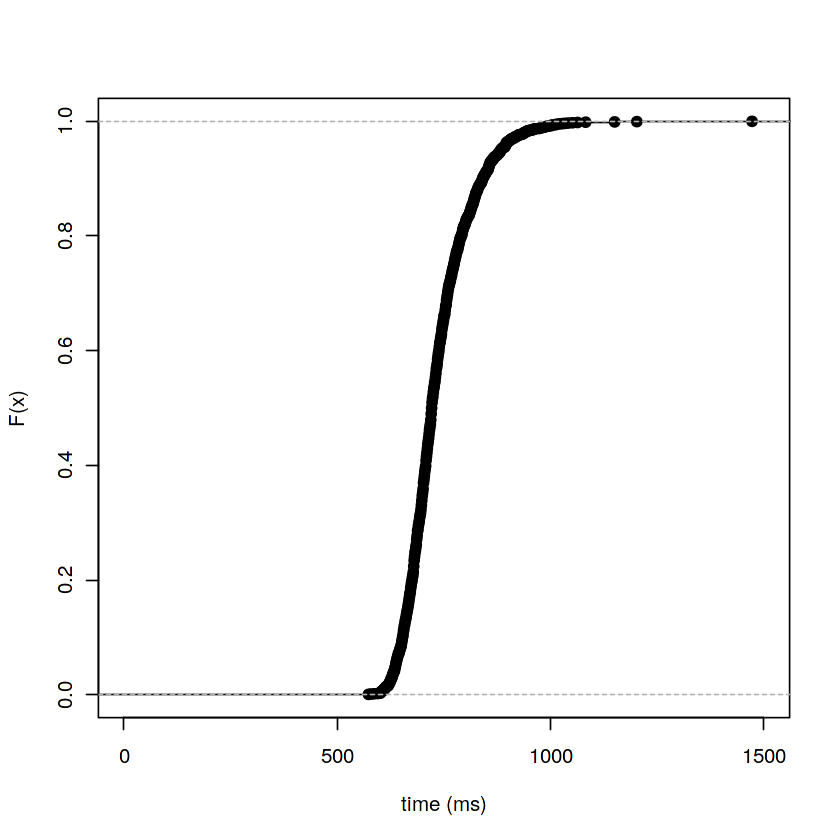

In [9]:
# plot cumulative density function
plot(ecdf(vb$rt), xlab = "time (ms)", ylab = "F(x)", main = "", xlim = c(0,1500))

As we know from above, the shortest response time is 573 ms, so that is when the cumulative density curve starts to increase. Before that time point, the proportion of verbs responded to is 0. The curve then steadily increases. At 600 ms, only 0.25 percent of verbs have been reponded to. At 900 ms, 96.5 percent - almost all verbs - have been responded to. The function returns 1 when all trials have been responded to, which is at 1472 ms and later. The cumulative density function can also be described as the integral over the probability density function from minus infintiy to time t.

In [10]:
# generate empirical cumulative density function
cdf = ecdf(vb$rt)
# access the environment of cdf
cdf = environment(cdf)

# proportion of trials that are responded to at 600 ms
cdf$y[which(cdf$x==600)]
# proportion of trials that are responded to at 900 ms
cdf$y[which(cdf$x==900)]
# proportion of trials that are responded to at 1472 ms
cdf$y[which(cdf$x==1472)]

[1] 0.002527806

[1] 0.9646107

[1] 1

## 2. The Survival Function
Based on the probability density function and the cumulative density function, there are three objective functions that are relevant for time-to-event analysis. The first of these functions is the survival function, which describes the probability that an event of interest has not yet occurred prior to or at a certain time point. The survival function is thus 1 minus the cumulative density function. For plotting the survival function, we need to define a survival object which encodes the time event tuple. We therefore define a new 'status' column in our dataset and set it to 1 for all verbs, since all trials have been responded to. Then, we use the survival object to estimate the survival function with the Kaplan-Meier estimate, and visualise the function in a plot.

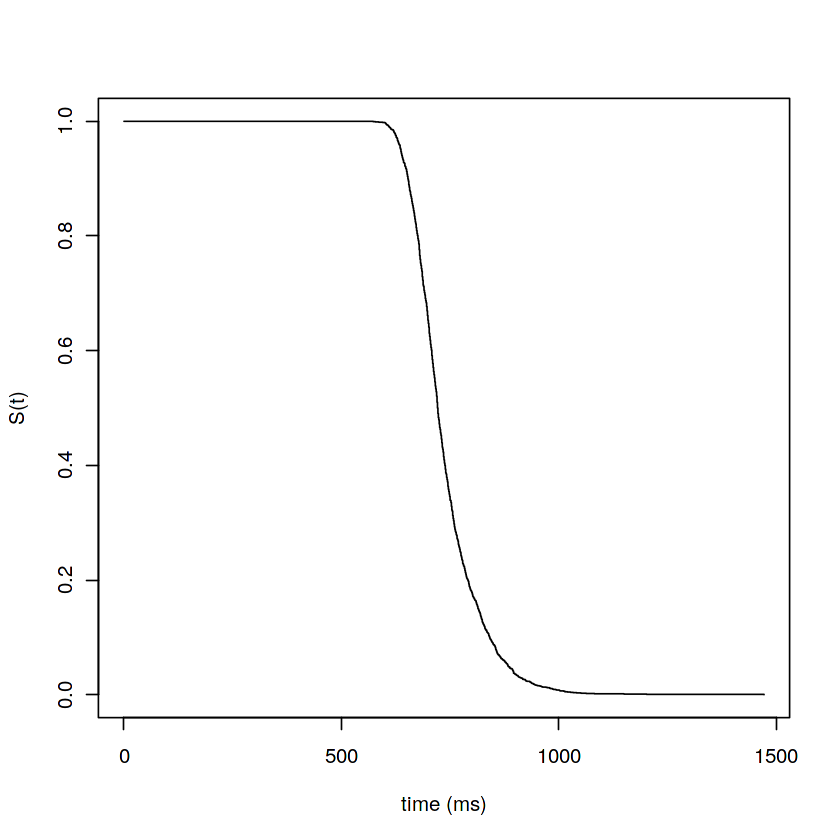

In [11]:
# define status column
vb$status = 1

# define survival object
surv = Surv(time = vb$rt, event = vb$status)
# estimate survival function (Kaplan-Meier estimate)
survival = survfit(surv ~ 1)

# survival plot
plot(survival, xlab = "time (ms)", ylab = "S(t)", conf.int = FALSE)

The resulting curve for the survival function is the inverted image of the cumulative densitiy function. For our response time data, the cumulative density function gave information about the proportion of trials that have been responded to at a certain time point. The survival function, in contrast, shows the proportion of trials that have *not yet* been responded to at a certain time point. At 600 ms, for instance, 99.7 percent of the verbs have not been responded to. At 900 ms, all but 3.5 percent of trials have been responded to, and when the verb with the longest response time has been responded to at 1472 ms, the value of the survival function is 0, meaning that all trials have been responded to. 

In [12]:
# proportion of trials that have not been responded to at 600 ms
survival$surv[which(survival$time==600)]
# proportion of trials that have not been responded to at 900 ms
survival$surv[which(survival$time==900)]
# proportion of trials that have not been responded to at 1472 ms
survival$surv[which(survival$time==1472)]

[1] 0.9974722

[1] 0.03538928

[1] 0

## 3. The Hazard Function
Another objective function in time-to-event analysis is the hazard function. It describes the instantaneous probability (commonly referred to as hazard rate) of an event of interest occuring at time t, provided that it has not occurred prior to time t. Alternatively, the hazard function can be expressed as the ratio of the probability density function and the survival function. For our response time data, the hazard rate describes the instantaneous probability that a trial is responded to at time t, provided that it has not been responded to yet.<br>
For computing the hazard function, we use the probability density function and the survival function objects that have already been defined above. The density function object should be restriced to those times at which at least one response was registered. After defining the hazard function as the ratio of probability density function and survival function, it can be visualised in a plot. 

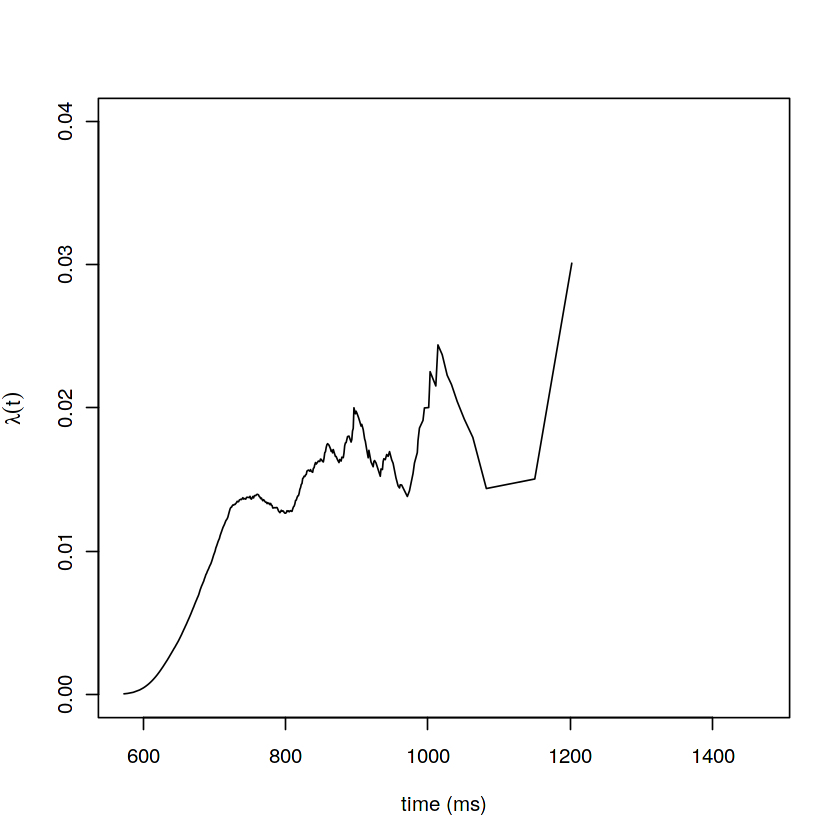

In [13]:
# already defined survival object surv and survival function survival
# already defined probability density function d

# restrict density object to times at which at least one response was registered
d$y = d$y[which(d$x%in%survival$time)]
d$x = d$x[which(d$x%in%survival$time)]

# define hazard function
hazard = d$y / survival$surv

# hazard function plot
plot(survival$time, hazard, type = "l", xlab = "time (ms)", ylab = expression(lambda(t)), ylim = c(0, 0.04))

The shape of the hazard function shows an increasing trend over time with occasional declines. It starts rising shortly before 600 ms, when the first responses start to come in. The rather choppy shape after 1000 ms is caused by a sparsity of registered response time data points. Interestingly, the curve terminates at approximately 1200 ms. However, we can see that the value at which the hazard function reaches its maximum is actually 1472, the time at which the last verb was responded to. 

In [14]:
# the value at which the hazard function reaches its maximum
survival$time[which(hazard==max(hazard))]

[1] 1472

Taking a look at verbs with response times longer than 1200 ms reveals that the point at which the hazard curve terminates (1202 ms) is the response time of the verb with the second longest response time. So why is there no representation in the plot for 1472 ms? The value of the hazard function at 1472 ms is infinity! This indeed cannot be represented on the graph. However, we should verify this result: the hazard rate is calculated as the ratio of probability density estimate and survival estimate at time t. At time 1472 ms, the probability density is 1 and the survival estimate is 0. And 1/0 is actually mathematically undefined. In R however, dividing a non-zero number by zero returns infinity. Explaining why R does this goes beyond the scope of this project, but it should still be pointed out that infinity is a result that makes sense in our case. Since all the trials in our data have been responded to, the hazard function assumes that any trial will eventually be responded to. The hazard of response becomes infinitely large with increasing time.

In [15]:
# verbs with a response time longer than 1200 ms
vb[which(vb$rt > 1200),]

,word,rt,regularity,log.frequency,length,log.old20,snd,status
,<chr>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1952,repatriate,1202,regular,1.386294,10,1.266948,0.6653110,1
1961,bivouac,1472,regular,2.302585,7,1.321756,0.5374669,1


In [16]:
# hazard function estimate at 1472 ms
hazard[which(survival$time==1472)]

# hazard function estimate at 700 ms
hazard[which(survival$time==700)]
# hazard function estimate at 1001 ms
hazard[which(survival$time==1001)]
# hazard function estimate at 1202 ms
hazard[which(survival$time==1202)]

# ratio of hazard function estimates at 700 ms and 1001 ms
hazard[which(survival$time==700)] / hazard[which(survival$time==1001)]

[1] Inf

[1] 0.009880459

[1] 0.02003209

[1] 0.03010014

[1] 0.4932315

We can, of course, still inspect the hazard function estimates for some time points for which we have recorded data and see how the hazard function is different from the probability density function. Compare: the probability density describes the overall likelihood of a response at a given time, whereas the hazard function estimates the probabilty of a response at a given time *provided that no response was given prior to that time*. At 700 ms, the hazard rate is at 0.009, at 1001 ms, it is at 0.02 and the ratio of the estimates at these time points is 0.49. The ratio of the probability density estimates at these time points was 41.6. For the verb with the second longest response time, 1202 ms, the hazard rate is 0.03, which is also the peak value of the hazard function.  

## 4. The Cumulative Hazard Function
The third objective function in time-to-event analysis is the cumulative hazard function. It is defined as the integral over the hazard function and describes the total amount of risk that an observation has been exposed to at a given point in time. The cumulative hazard function can also be plotted.

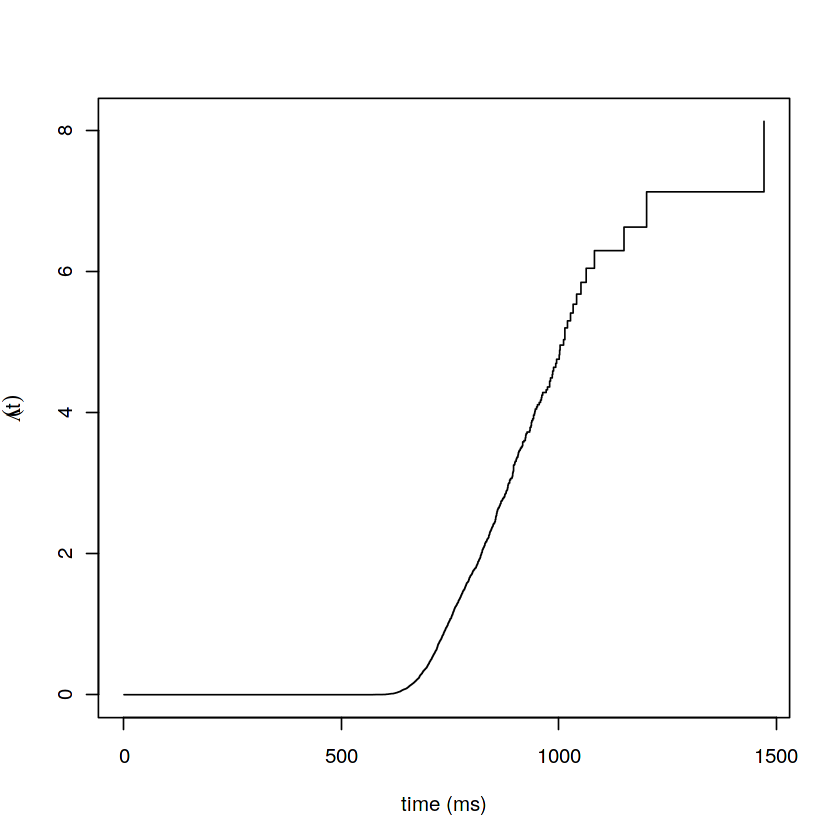

In [17]:
# cumulative hazard plot
plot(survival, cumhaz = TRUE, conf.int = FALSE, xlab = "time (ms)", ylab = expression(Lambda(t)))

The curve of the cumulative hazard function increases over time. Its slope represents the value of the hazard function.

## 5. Regularity as a Categorical Predictor
After having inspected the overall nature of our dataset and the distribution of response times by means of the three objective functions, we can turn to even more interesting questions and see whether certain predictors like regularity of the verb, word length, or frequency have an effect on the shape of the survival, hazard, and cumulative hazard functions.<br>
The most obvious predictor of interest in the context of past tense verb inflection is the verb's regularity. Regularity is a categorical predictor with two values: regular and irregular. By analysing the effect that regularity has on the objective functions, we can answer questions such as the following: "Is the proportion of trials in the past tense generation experiment that has been responded to at time t different for regular and irregular verbs?" or "Does the regularity of a verb co-determine the probability that a verb is not responded to by time t?".<br>
First, we extract relevant information from the survival curve that we fitted above and store it in a data frame named surv.sum.

In [18]:
# create summary of survival curve
surv.sum = surv_summary(survival)
# inspect
head(surv.sum[,-4])
dim(surv.sum)

length(unique(vb$rt))

,time,n.risk,n.event,surv,std.err,upper,lower
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,573,1978,1,0.9994944,0.0005056890,1.0000000,0.9985043
2,578,1977,1,0.9989889,0.0007153332,1.0000000,0.9975892
3,586,1976,1,0.9984833,0.0008763224,1.0000000,0.9967698
4,595,1975,1,0.9979778,0.0010121463,0.9999595,0.9960000
5,600,1974,1,0.9974722,0.0011319007,0.9996875,0.9952618
6,601,1973,1,0.9969666,0.0012402494,0.9993931,0.9945461


[1] 349   8

[1] 349

The resulting dataframe surv.sum contains data about all time points at which at least one response was registered, that is, it contains as many rows as there are unique response time values in our dataset vb. For each point in time, the number of trials at risk (i.e., the number of trials not yet responded to), the number of events (i.e., the number of responses at that point in time), and the survival rate at the corresponding point in time are provided. Additionally, the columns <code>std.error</code>, <code>upper</code> and <code>lower</code> provide information about the amount by which the true survival function at time t is likely to differ from the estimated survival function, and about the upper and lower bounds of the 95% confidence interval for the value of the true survival function.<br>
The next step is fitting separate survival curves for the levels of the regularity predictor. For this, we first need to convert the regularity column to a factor. Then we can fit the survival curves and inspect the result.

In [19]:
# convert regularity column to factor
vb$regularity = factor(vb$regularity, levels = c("regular", "irregular"))
# generate survival curves
surv.cat = survfit(surv ~ regularity, data = vb)
# inspect survival curves
surv.cat

Call: survfit(formula = surv ~ regularity, data = vb)

                        n events median 0.95LCL 0.95UCL
regularity=regular   1824   1824    718     715     721
regularity=irregular  154    154    797     779     816

There are 1824 ovservations for regular verbs and 154 observations for irregular verbs. The number of events is equal to the number of respective observations, because all trials in the past tense generation data were responded to. The median response time for regular verbs is shorter than for irregular verbs and their confidence intervals do not overlap, suggesting that there is a substantial difference between the survival curves for regular and irregular verbs. A statistical test will reveal whether this difference is reliable and reflects a true difference for English verbs in general. Before testing, we extract more details about the two survival curves:

In [20]:
# create summary of survival curve
surv.cat.sum = surv_summary(surv.cat, data = vb)

# define columns of interest
cols = c("time","surv","upper","lower","regularity")

# inspect survival curves at 710 ms
surv.cat.sum[which(surv.cat.sum$time == 710), cols]
# inspect survival curves at 895 ms
surv.cat.sum[which(surv.cat.sum$time == 895), cols]
# inspect survival curves at 1014 ms
surv.cat.sum[which(surv.cat.sum$time == 1014), cols]

,time,surv,upper,lower,regularity
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
112,710,0.5493421,0.5726572,0.5269762,regular
345,710,0.9155844,0.9605628,0.8727122,irregular


,time,surv,upper,lower,regularity
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
282,895,0.03673246,0.04646362,0.02903935,regular
439,895,0.09090909,0.14980060,0.05516976,irregular


,time,surv,upper,lower,regularity
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
324,1014,0.004934211,0.009467834,0.0025714891,regular
452,1014,0.006493506,0.045804978,0.0009205468,irregular


The value of the survival functions provide insight into the proportion of trials that have not been responded to at a certain point in time for both levels of the regularity predictor. Inspecting different time points reveals that the survival rate is higher for irregular verbs than for regular verbs across multiple time points in the analysis window. At 710 ms, for instance, almost half of the regular verbs have been responded to while more than 90 percent of irregular verbs have not yet been responded to. The difference between survival rates of regular and irregular verbs seems to decrease over time. To complement the numerical inspection of the survival curves with visual information, we can plot the two curves for regular and irregular verbs:

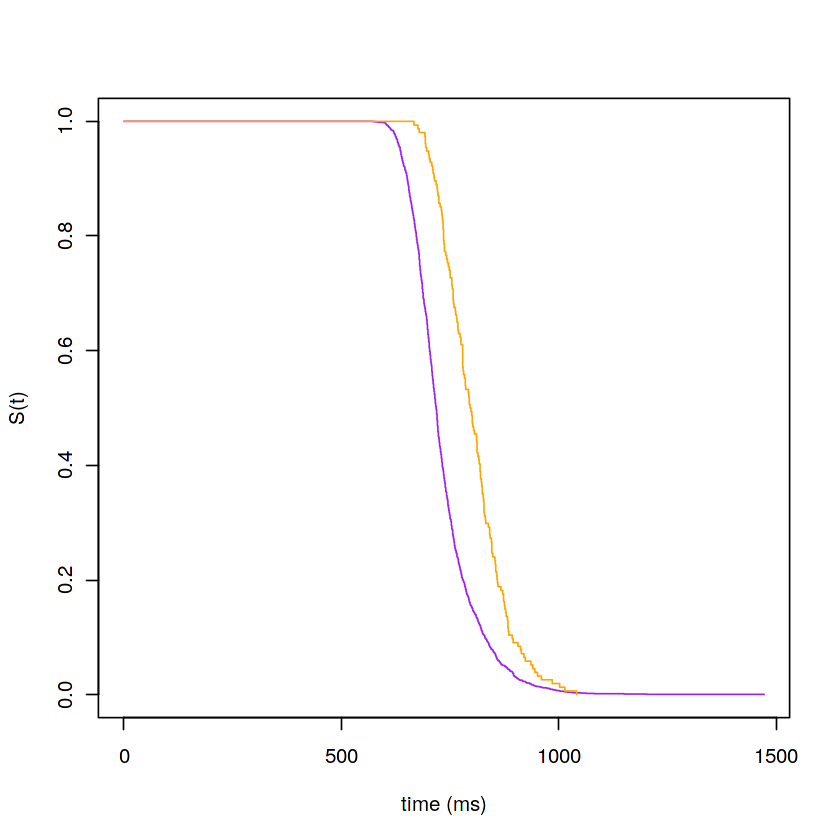

In [21]:
# plot survival curves
plot(surv.cat, xlab = "time (ms)", ylab = "S(t)", col = c("purple","orange"))

The plot shows that the survival curves for regular verbs (purple) and irregular verbs (orange) are similar in shape but show a divergence between 600 ms and 1000 ms after stimulus onset. As noted during the numerical inspection, survival rates are higher for irregular words than for regular words in that period. This difference is also reflected in the response time distribution of regular and irregular verbs. Below is the plot of the probability density function for the two levels of regularity, which visualises the displacement between the two curves. We can see that regular verbs start to be responded to earlier than irregular verbs and also finish to be responded to earlier. To check the reliability of this difference, we can conduct a statistical test.

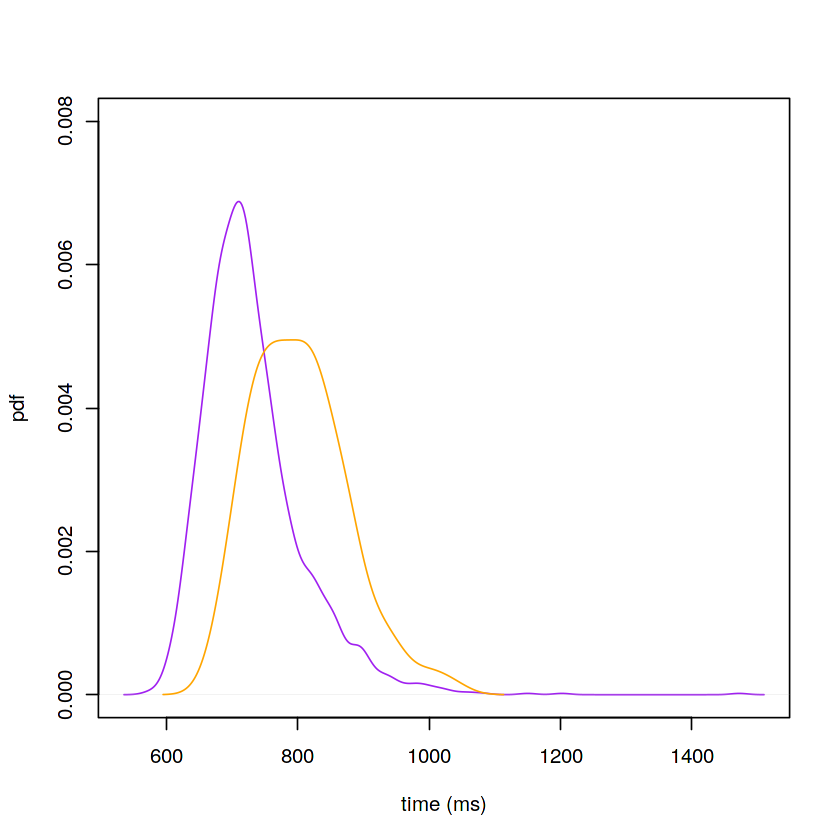

In [22]:
# plot the probability density function for regular verbs
plot(density(vb$rt[which(vb$regularity == "regular")]), xlab = "time (ms)", 
     ylab = "pdf", main = "", ylim = c(0, 0.008), col = "purple")
# add probability density function for irregular verbs
lines(density(vb$rt[which(vb$regularity == "irregular")]), col = "orange")

#### Statistical Test
The log-rank test is the most common statistical test for finding out whether the event time distributions for the values of a categorical predictor are different. It compares the estimates of the hazard function for the levels of the categorical predictor at each time point. The aim of the log-rank test is to decide whether we can reject the null-hypothesis (i.e., the hypothesis that there is no difference between the hazard functions for regular and irregular verbs).

In [23]:
# statistical test
surv.cat.test = survdiff(surv ~ regularity, data = vb)

# inspect
surv.cat.test

Call:
survdiff(formula = surv ~ regularity, data = vb)

                        N Observed Expected (O-E)^2/E (O-E)^2/V
regularity=regular   1824     1824     1697      9.46      68.6
regularity=irregular  154      154      281     57.20      68.6

 Chisq= 68.6  on 1 degrees of freedom, p= <2e-16 

The output of the log-rank test the number of observed end expected events for both values of regularity. The number of expected events indicates how many events we would have expected across all time points for each regularity value if the hazard functions for regular and irregular verbs were identical. For regular verbs, the number of observed events is higher than the expected value, whereas for irregular verbs, the number of observations is lower than what we would expect if the hazard functions were identical. Based on the differences between observed and expected values, we get a test statistic of 68.6 and a *p*-value of p<2e-16, which is an extremely small probability that the null hypothesis is true. Therefore, we can reject the null hypothesis and accept the alternative hypothesis: there is a difference between the hazard functions for regular and irregular verbs. Hazard rates are higher for regular verbs than for irregular verbs. Hence, survival rates are lower for regular verbs as compared to irregular verbs.

## 6. Numerical Predictors
Next, we want to check what effect numerical predictors, for example semantic neighbourhood density (snd), have on the hazard rates. There are two statistical models that test the null hypothesis that a numerical predictor does not influence hazard rates: the Cox proportional hazards model and the Aalen additive hazards model.
### 6.1 Cox proportional hazards model
For testing how the numerical predictor <code>snd</code> (the semantic similarity of the target verb to other words) influences response times in the past tense generation dataset, we first fit the Cox proportional hazards model to model the time event tuple as a function of the snd of a verb. By means of the test statistic *z*, the model will evaluate whether there is enough evidence to reject the null hypothesis that the regression coefficient for the numerical predictor <code>snd</code> is zero.

In [24]:
# fit Cox proportional hazards model for snd
cox.snd = coxph(Surv(rt,status) ~ snd, data = vb)
# show model summary
summary(cox.snd)

Call:
coxph(formula = Surv(rt, status) ~ snd, data = vb)

  n= 1978, number of events= 1978 

      coef exp(coef) se(coef)     z Pr(>|z|)    
snd 0.8151    2.2594   0.2448 3.329 0.000871 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    exp(coef) exp(-coef) lower .95 upper .95
snd     2.259     0.4426     1.398     3.651

Concordance= 0.52  (se = 0.008 )
Likelihood ratio test= 11.14  on 1 df,   p=8e-04
Wald test            = 11.08  on 1 df,   p=9e-04
Score (logrank) test = 11.09  on 1 df,   p=9e-04


The coefficient for snd is 0.8151 and the *p*-value of 0.000871 indicates that the null hypothesis can be rejected. We accept the alternative hypothesis that the coefficient for the numerical predictor snd is not null. The Cox proportional hazards model thus suggests that the semantic similarity of a verb to other words influences the shape of the hazard function in the past tense generation task. A next step is to investigate how the shape is influenced by the snd. The positive value of the regression coefficient (0.82) is indicative of increasing hazard rates. This means that hazard rates are substantially higher for words with higher snd. A higher snd value indicates that more words are semantically similar to the target verb. Hence, for verbs that have more semantic neighbours, the hazard rate (or the instantaneous probability of a response, provided that no response has been registered so far) is higher at any given time point in the past tense generation task than for verbs with few semantic neighbours. The same is also indicated by the exp(coef) 2.259, since it has a value greater than 1.<br>
Now that we have inspected the hazard rates for different values of snd, we can make use of the mathematical relation between the hazard function and the survival function to also compare estimated survival curves for different snd values. We request survival curves for the 0.1, 0.5 and 0.9 quantiles of the snd distribution. They correspond to snd values of 0.54, 0.67 and 0.77, respectively. Then, we generate the survival curves for the three quantiles.

In [25]:
# create data frame for predictions
newdata.snd = data.frame("snd" = quantile(vb$snd, c(0.1, 0.5, 0.9)))

# inspect data frame
newdata.snd

,snd
,<dbl>
10%,0.5435572
50%,0.6670411
90%,0.7699681


In [26]:
# generate survival curves
surv.snd = survfit(cox.snd, newdata = newdata.snd)
# inspect survival curves
surv.snd

Call: survfit(formula = cox.snd, newdata = newdata.snd)

       n events median 0.95LCL 0.95UCL
10% 1978   1978    727     722     732
50% 1978   1978    721     719     725
90% 1978   1978    718     714     721

The median response times for verbs at the 0.10, 0.50, and 0.90 quantiles of the snd distribution are 727 ms, 721 ms, and 718 ms, respectively. Consistent with the positive hazard ratio for snd in the Cox proportional hazards model, response times thus are shorter for verbs with high snd, that is, with many semantic neighbours. However, the effect is not very large. The difference between the median response times for verbs in the 0.1 and 0.9 quantile is only 9 ms and the borders of the 95% confidence intervals overlap between the quantiles.
A summary of the survival curves provides estimates of the proportion of verbs at each quantile of the snd distribution that have not been responded to a a certain point of time.

In [27]:
# create summary of survival curves
surv.snd.sum = surv_summary(surv.snd)
# define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# inspect survival curves at 600 ms
surv.snd.sum[which(surv.snd.sum$time==600), cols]
# inspect survival curves at 1200 ms
surv.snd.sum[which(surv.snd.sum$time==900), cols]

,time,surv,upper,lower,strata
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,600,0.9977107,0.9997217,0.9957037,10%
354,600,0.9974686,0.9996871,0.9952550,50%
703,600,0.9972473,0.9996635,0.9948371,90%


,time,surv,upper,lower,strata
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
291,900,0.04755073,0.06221481,0.03634298,10%
640,900,0.03444157,0.04346693,0.02729022,50%
989,900,0.02564827,0.03531876,0.01862562,90%


The small effect of snd on the response times is reflected in the values of the survival function at different time points. At 600 ms after stimulus onset, 99.77 percent of verbs with low snd at the 0.1 quantile have not been responded to and the proportion barely drops to 99.72 percent for verbs in the 0.9 quantile. Also at 1200 ms, the difference between 3.9 percent at the 0.1 quantile and 3.1 percent at the 0.9 quantile is small, though not as small as at 600 ms. Again, the borders of the corresponding 95% confidence intervals of the three quantiles overlap. A plot of the three survival curves for the quantiles will certainly reflect the small effect, as well:

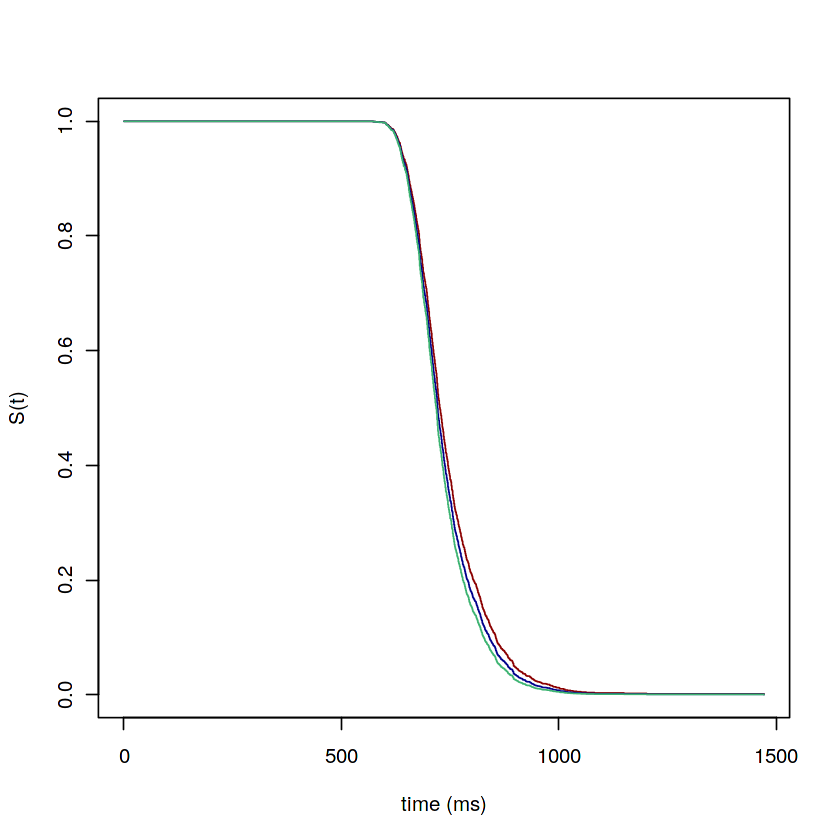

In [28]:
# plot survival curves
plot(surv.snd, xlab = "time (ms)", ylab = "S(t)",
col = c("darkred", "blue4", "mediumseagreen"))

As expected, the curves of the 0.1 (red), 0.5 (blue) and 0.9 (green) quantiles of the snd distribution do not deviate much, but it is still visible that the survival probabilities are higher for verbs with low snd than for verbs with high snd. Even though we cannot see whether the lines cross at some time point in the plot, the numerical inspection of the survival curves we did before gives evidence that this deviation holds true throughout the whole response time window.<br>
The fan-like deviation of the survival curves is a typical pattern of results for a Cox proportional hazards model due to the assumption that the ratio of hazard rates for different predictor values is required to be constant over time. However, when this assumption is not true, the fit of a Cox proportional hazards model is not accurate. A statistical test can evaluate whether the null hypothesis that the proportional hazards assumption holds true has to be rejected.

In [29]:
# check proportional hazards assumption
cox.zph.snd = cox.zph(cox.snd)
# inspect results
cox.zph.snd

          chisq df    p
snd    0.000191  1 0.99
GLOBAL 0.000191  1 0.99

On the basis of the *p*-value 0.99, the null hypothesis cannot be rejected. This indicates that a Cox proportional hazards model accurately captures the effect of snd on the hazard function for the past tense generation data. A Schoenfeld residuals plot provides visual information.

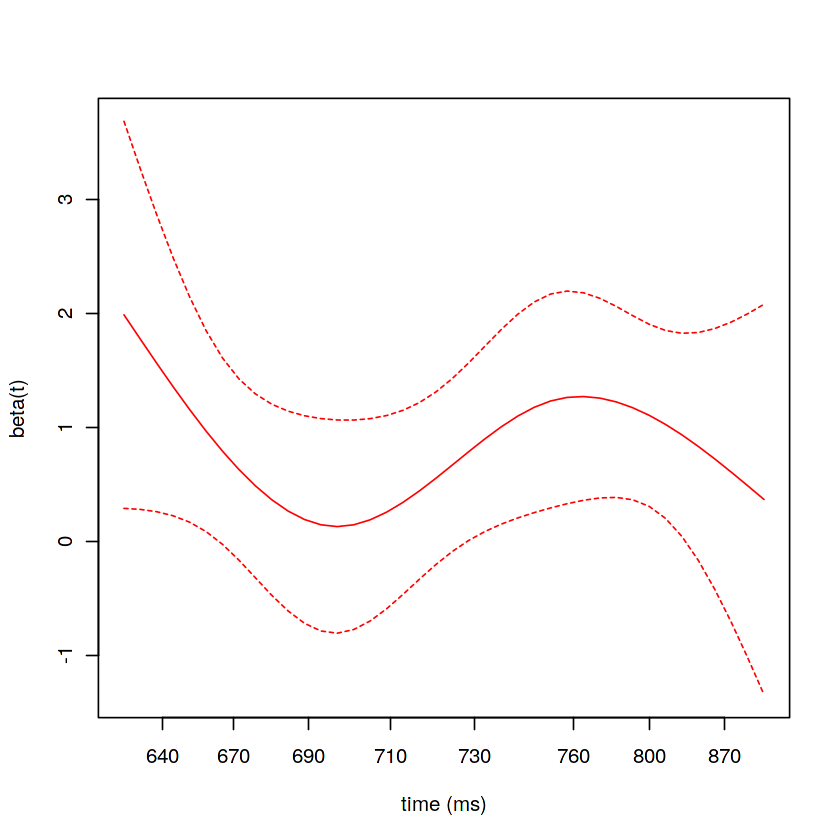

In [30]:
# Schoenfeld residuals plot
plot(cox.zph.snd, resid = FALSE, xlab = "time (ms)", ylab = "beta(t)", col = "red")

The curve for the Schoenfeld residuals shows variation over time. Contradictory to the statistical test, this means that the proportional hazards assumption does not hold true and indicates that the Cox proportional hazards model does not provide an adequate estimate of the effect of snd on response times.

### 6.2 Aalen additive hazards model
When the proportional hazards assumption does not hold true, there is a second statistical model that can be used for testing the effect of numerical predictors on hazard rates, namely the Aalen additive hazards model. In contrast to the Cox proportional hazards model, the Aalen additive hazards model provides insight into the temporal nature of the predictor's effect. We fit a model to the respose time data to check the effect of snd.

In [31]:
# fit Aalen additive hazards model to the data
aareg.snd = aareg(Surv(rt,status) ~ snd, data = vb)
# inspect results
aareg.snd

Call:
aareg(formula = Surv(rt, status) ~ snd, data = vb)

  n= 1978 
    347 out of 349 unique event times used

             slope     coef se(coef)    z        p
Intercept 0.000745 0.000502 0.000158 3.17 0.001510
snd       0.001270 0.000839 0.000239 3.51 0.000453

Chisq=12.3 on 1 df, p=0.000453; test weights=aalen

The *z*-value resulting from the Aalen additive hazards model fit is similar to the one in the output of the Cox proportional hazards model. The *p*-value for the null hypothesis that a verb's snd value does not influence the hazard function is small (0.000453). Hence, the null hypothesis can be rejected and we conclude that the snd value of a verb has an effect on the shape of the hazard function. Furthermore, the value of the slope column for snd is positive, indicating that overall hazard rates are higher for words with high snd. This makes the results of the Aalen additive hazards model consistent with those of the Cox proportional hazards model. To find out whether the effect of snd on the hazard function varies as a function of time, we plot the results of the Aalen additive regression model.

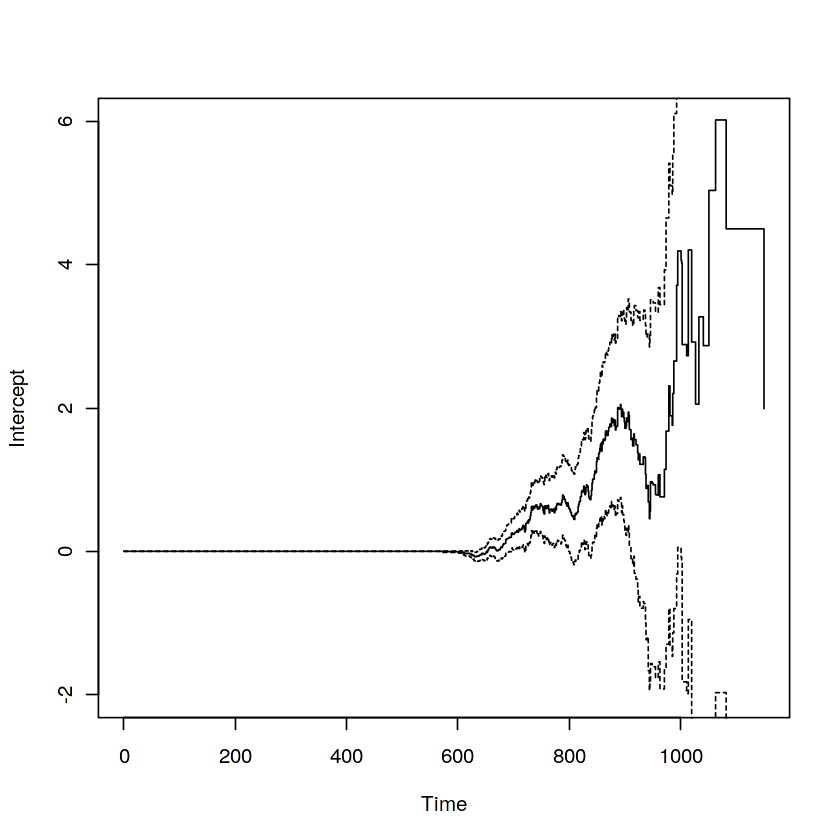

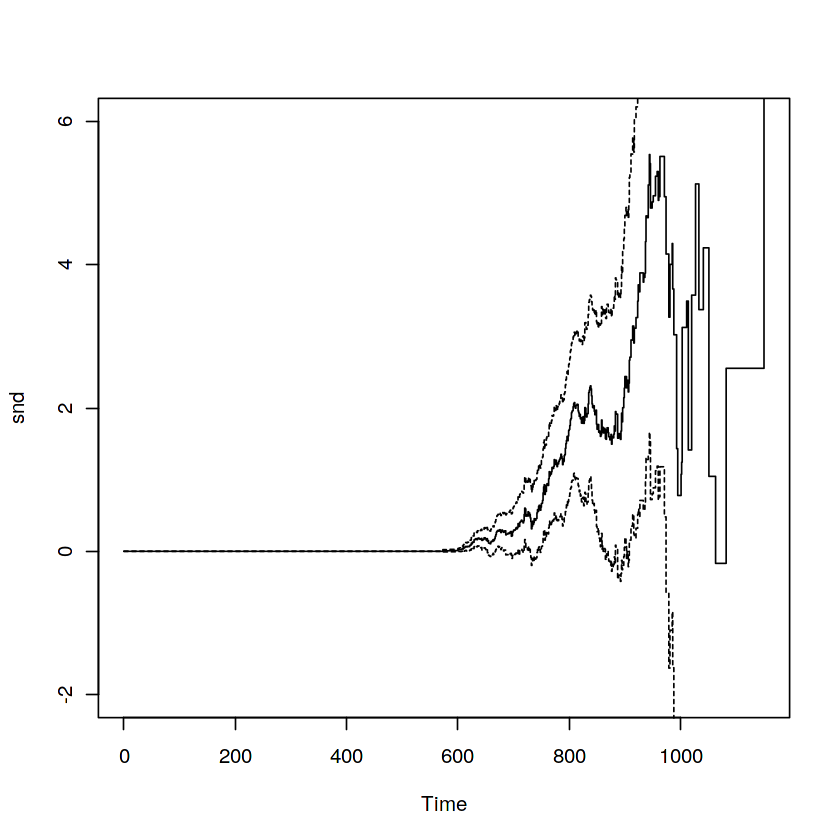

In [32]:
# cumulative coefficient plot
plot(aareg.snd, ylim=c(-2,6))

What got plotted is the cumulative coefficient B, that is, the sum of the hazard rates of all time points up to and including a given time t. The slope of the curve for the cumulative coefficient at time t can be interpreted as the
modification to the hazard at time t. Between 600 ms and 800 ms after stimulus onset, the curve increases. During this period, the hazard rate is higher for verbs with high snd than for verbs with low snd. Between 800 ms and 900 ms, the curve decreases slightly, indicating that during this time, the hazard rate is lower for high snd verbs than for low snd verbs. After a steep increase of the curve between 900 ms and 1000 ms, it decreases sharply, increases again and then repeats this alternating pattern once more. This pattern can not really be interpreted, other than noting that the data points with response times longer than 1000 ms are rather scarce, so that the curve shows these uneven oscillations.

## 7. Multiple predictors
We have already established the effects of some of the predictors in our data on the shape of the objective functions. The categorical predictor <code>regularity</code> has an effect on hazard and survival rates, as does the numerical predictor <code>snd</code>.  
Now we would like to know if any of the remaining predictors <code>length</code>, <code>log.frequency</code>, and <code>log.old20</code> has a significant effect on the shape of the survival function, the hazard function, or the cumulative hazard function. For this, both the Cox proportional hazards model and the Aalen additive hazards model allow for the inclusion of multiple predictors at once. 
### 7.1 Cox proportional hazards model
We first fit a Cox proportional hazards model to the data to find out if the length of a verb, its frequency, or the orthographic similarity of a verb to other words influence the shape of the hazard function in the past tense generation task.

In [33]:
# fit Cox proportional hazards model
cox.mult = coxph(Surv(rt,status) ~ length + log.frequency + log.old20, data = vb)
# Show model summary
summary(cox.mult)

Call:
coxph(formula = Surv(rt, status) ~ length + log.frequency + log.old20, 
    data = vb)

  n= 1978, number of events= 1978 

                  coef exp(coef) se(coef)      z Pr(>|z|)   
length        -0.01948   0.98071  0.02530 -0.770  0.44126   
log.frequency  0.03027   1.03073  0.01048  2.889  0.00387 **
log.old20      0.29744   1.34641  0.14198  2.095  0.03618 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
length           0.9807     1.0197    0.9333     1.031
log.frequency    1.0307     0.9702    1.0098     1.052
log.old20        1.3464     0.7427    1.0193     1.778

Concordance= 0.535  (se = 0.008 )
Likelihood ratio test= 11.54  on 3 df,   p=0.009
Wald test            = 11.47  on 3 df,   p=0.009
Score (logrank) test = 11.47  on 3 df,   p=0.009


The model summary reports that the *p*-values for the null hypothesis of the model as a whole are small (0.009). We therefore reject the null hypothesis that all estimated coefficients are zero and accept the alternative hypothesis that at least one of the predictors significantly influences the shape of the hazard function. To determine which of the three predictors have an effect, we take a look at the corresponding *p*-values. The *p*-values for <code>log.frequency</code> and <code>log.old20</code> are small. We therefore reject the null hypothesis that their coefficient is zero and accept the alternative hypothesis. For the <code>length</code> predictor, the *p*-value is too high to reject the null hypothesis. The results of the Cox proportional hazards model thus indicate that word frequency and orthographic neighbourhood have a significant effect on the shape of the hazard function, whereas word length does not.<br>
We can further inspect the coefficients for each predictor to get more information about the qualitative and quantitative nature of the predictor effects. The coefficients for <code>log.frequency</code> and <code>log.old20</code> are positive, indicating that hazard rates are higher for high frequency verbs and for verbs with high old20 (i.e., verbs with fewer orthographic neighbours). At each point in time, the hazard rate for <code>log.frequency</code> is multiplied by 1.03 when frequency increases by 1 and the hazard rate for <code>log.old20</code> is multiplied by 1.34 when old increases by 1. The coefficient for <code>length</code> is close to zero, but negative, indicating that hazard rates are higher for short words, although this effect is not significant.<br>
We would also like to visualise survival curves for different values of the predictors of interest. First we do this for the <code>log.frequency</code> predictor. We therefore convert the hazard rates estimated by the Cox proportional hazards model into estimates of survival probabilities by means of the <code>survfit()</code> function with a new dataframe containing values of word frequency for which we would like to obtain survival curves. Here, the 0.1, 0.5 and 0.9 quantiles of the word frequency distribution are chosen.

In [34]:
# create data frame for predictions
newdata.freq = data.frame(
    "log.frequency" = quantile(vb$log.frequency,c(0.1, 0.5, 0.9)),
    "log.old20" = mean(vb$log.old20),
    "length" = mean(vb$length)
)
# show data frame
newdata.freq

,log.frequency,log.old20,length
,<dbl>,<dbl>,<dbl>
10%,2.397895,0.6411304,6.043478
50%,4.859812,0.6411304,6.043478
90%,8.164151,0.6411304,6.043478


In [35]:
# generate survival curves
surv.freq = survfit(cox.mult, newdata = newdata.freq)
# inspect survival curves
surv.freq

Call: survfit(formula = cox.mult, newdata = newdata.freq)

       n events median 0.95LCL 0.95UCL
10% 1978   1978    726     721     731
50% 1978   1978    722     720     725
90% 1978   1978    718     713     721

The output of the <code>survfit()</code> function provides the median response times for verbs at the 0.1, 0.5, and 0.9 quantiles of the word frequency distribution with average word length (6.04) and average old value (0.64). The difference between the conditional median response times for verbs at the 0.1 and 0.9 quantiles is 8 ms only, indicating that the effect of word frequency is rather small. More detailed insight into the survival curves at the quantiles of the word frequency distribution is available through a summary of the survival curves.

In [36]:
# create summary of survival curves
surv.freq.sum = surv_summary(surv.freq)
# define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# inspect survival curves at 700 ms
surv.freq.sum[which(surv.freq.sum$time==700), cols]

,time,surv,upper,lower,strata
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102,700,0.6702385,0.6959129,0.6455113,10%
451,700,0.6498104,0.6711923,0.6291096,50%
800,700,0.6210052,0.6503614,0.5929742,90%


Consistent with the results of the Cox proportional hazards model, survival probabilities are higher for high frequency words as compared to low frequency words. At 700 ms after stimulus onset, for instance, the survival probabilities for words at the 0.1, 0.5, and 0.9 quantiles of the word frequency distribution are 0.67, 0.65, and 0.62, respectively. However, we can see that the difference is rather small. We can also check this by visualising the three survival curves for the frequency quantiles in a plot.

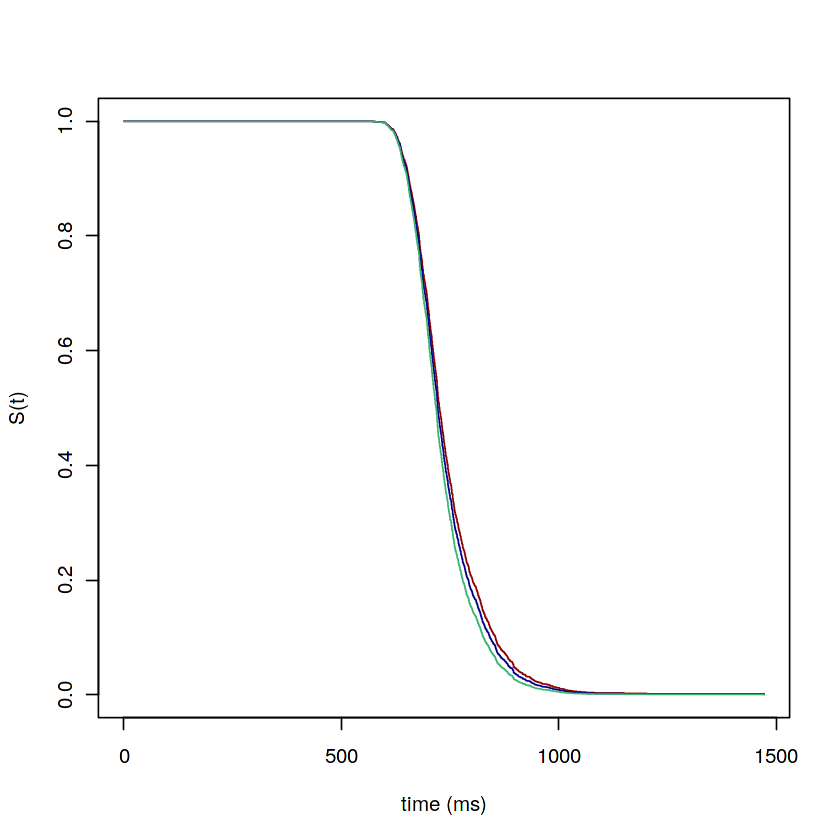

In [37]:
# plot survival curves for frequency
plot(surv.freq, xlab = "time (ms)", ylab = "S(t)",
col = c("darkred", "blue4", "mediumseagreen"))

As expected, the curves barely diverge. Survival probabilities are a bit higher for low frequency words (red) as compared to high frequency words (green) throughout the response time window.
The same analysis of conditional survival curves is done for the <code>log.old20</code> predictor below.

,log.old20,log.frequency,length
,<dbl>,<dbl>,<dbl>
10%,0.04879016,5.13206,6.043478
50%,0.61518564,5.13206,6.043478
90%,1.11514159,5.13206,6.043478


Call: survfit(formula = cox.mult, newdata = newdata.old20)

       n events median 0.95LCL 0.95UCL
10% 1978   1978    732     722     745
50% 1978   1978    722     720     725
90% 1978   1978    715     708     722

,time,surv,upper,lower,strata
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102,700,0.6945927,0.7422221,0.6500197,10%
451,700,0.6496639,0.6711080,0.6289050,50%
800,700,0.6062563,0.6537624,0.5622022,90%


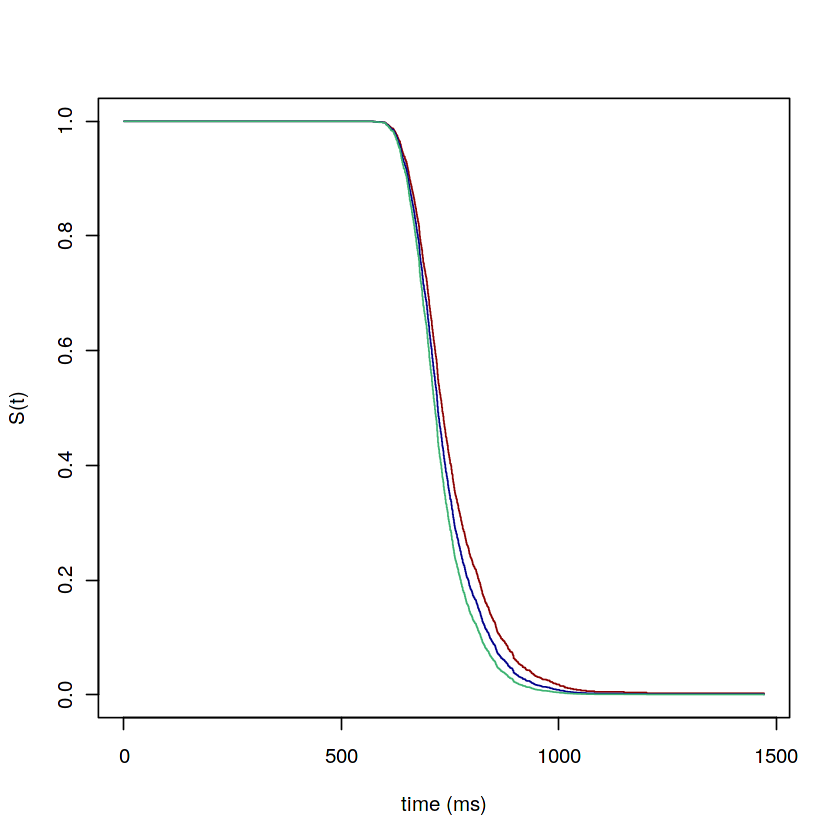

In [38]:
# create data frame for predictions 
newdata.old20 = data.frame(
    "log.old20" = quantile(vb$log.old20 ,c(0.1, 0.5, 0.9)),
    "log.frequency" = mean(vb$log.frequency),
    "length" = mean(vb$length)
)
# show data frame
newdata.old20

# generate survival curves
surv.old20 = survfit(cox.mult, newdata = newdata.old20)
# inspect survival curves
surv.old20

# create summary of survival curves
surv.old20.sum = surv_summary(surv.old20)
# define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# inspect survival curves at 700 ms
surv.old20.sum[which(surv.old20.sum$time==700), cols]

# plot survival curves for old20
plot(surv.old20, xlab = "time (ms)", ylab = "S(t)",
col = c("darkred", "blue4", "mediumseagreen"))

A numerical inspection of the survival curves for different values of <code>log.old20</code> reveals that the distances between the curves are greater than they were for the frequency predictor. The median values of the 0.1 and 0.9 quantiles of the old20 distribution differ by 17 ms. Survival probabilities are higher for verbs with many orthographically similar words than for verbs with high old20 value. At 700 ms after stimulus onset, for instance, the survival probabilities for verbs of the 0.1, 0.5 and 0.9 quantile of the old20 distribution are 0.69, 0.65 and 0.61, respectively. Plotting the three curves confirms these observations.<br>
Doing the same analysis with the <code>length</code> will confirm the result of the Cox proportional hazards model, namely that word length does not have a considerable effect. In a plot, the three survival curves are almost congruent:

,length,log.frequency,log.old20
,<dbl>,<dbl>,<dbl>
10%,4,5.13206,0.6411304
50%,6,5.13206,0.6411304
90%,9,5.13206,0.6411304


Call: survfit(formula = cox.mult, newdata = newdata.len)

       n events median 0.95LCL 0.95UCL
10% 1978   1978    720     715     726
50% 1978   1978    721     719     725
90% 1978   1978    724     718     735

,time,surv,upper,lower,strata
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102,700,0.6361684,0.6733317,0.6010562,10%
451,700,0.6472584,0.6686839,0.6265194,50%
800,700,0.6634403,0.7099323,0.6199930,90%


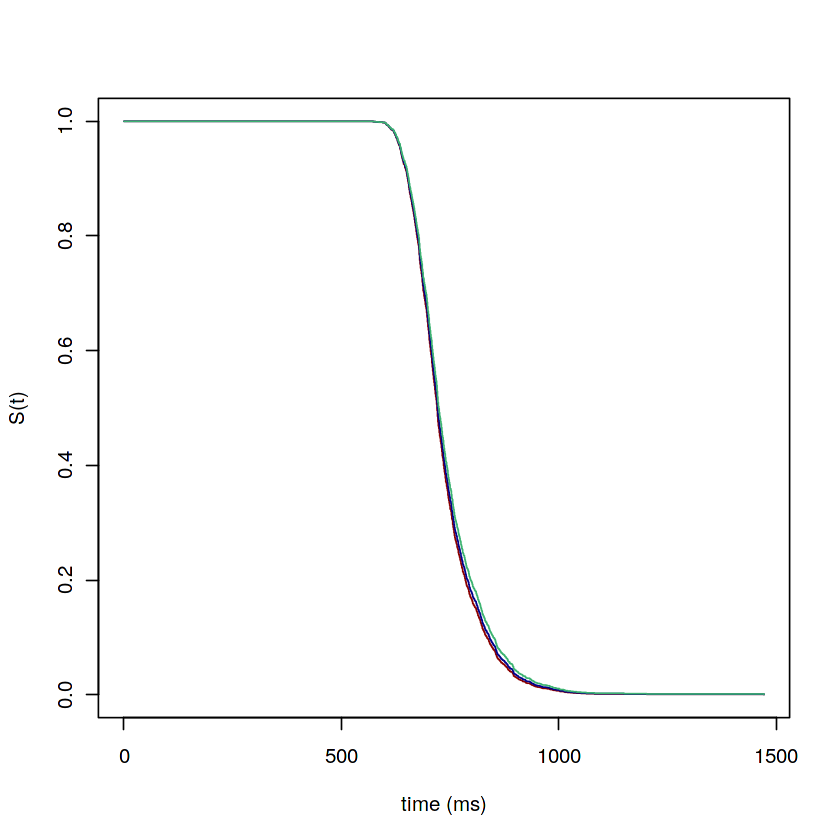

In [39]:
# create data frame for predictions
newdata.len = data.frame(
    "length" = quantile(vb$length ,c(0.1, 0.5, 0.9)),
    "log.frequency" = mean(vb$log.frequency),
    "log.old20" = mean(vb$log.old20)
)
# show data frame
newdata.len

# generate survival curves
surv.len = survfit(cox.mult, newdata = newdata.len)
# inspect survival curves
surv.len

# create summary of survival curves
surv.len.sum = surv_summary(surv.len)
# define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# inspect survival curves at 700 ms
surv.len.sum[which(surv.len.sum$time==700), cols]

# plot survival curves for word length
plot(surv.len, xlab = "time (ms)", ylab = "S(t)",
col = c("darkred", "blue4", "mediumseagreen"))

Again, the Cox proportional hazards model works under the assumption that the ratio of hazard rates for different predictor values is constant over time. We can check whether this assumption actually holds true for the three predictors.

In [40]:
# check proportional hazards assumption
cox.zph.mult = cox.zph(cox.mult)
# inspect results
cox.zph.mult

               chisq df       p
length         0.269  1 0.60383
log.frequency  7.246  1 0.00710
log.old20      1.120  1 0.28999
GLOBAL        19.540  3 0.00021

According to the output, we can reject the null hypothesis that hazard rates are constant over time for log.frequency. For length and log.old20, there is not enough evidence to reject the null hypothesis. Plotting the Schoenfeld residuals should give us more visual information.

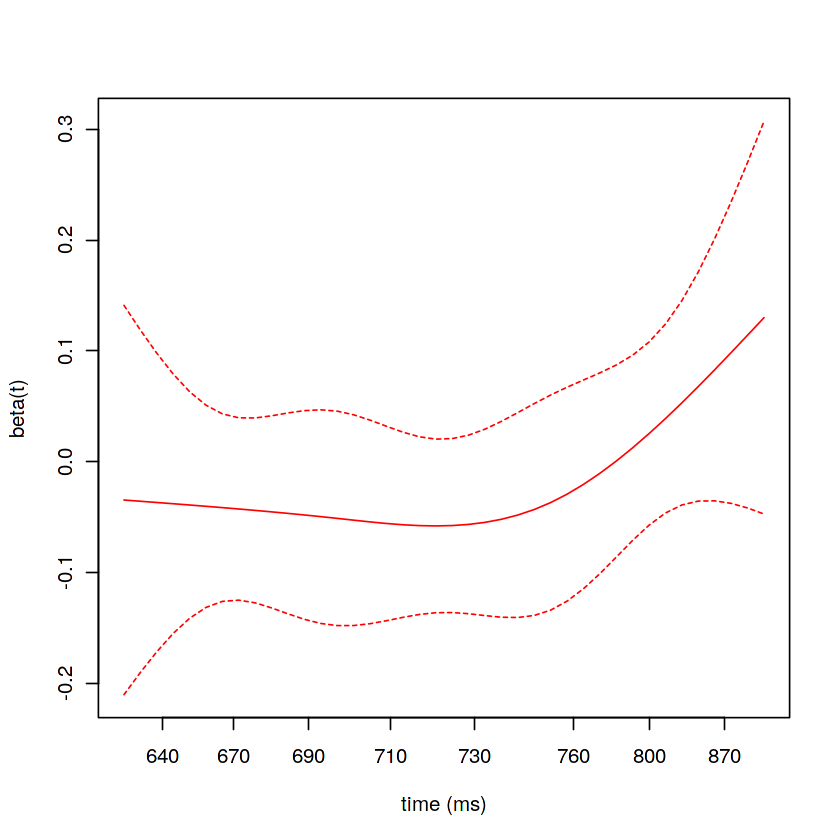

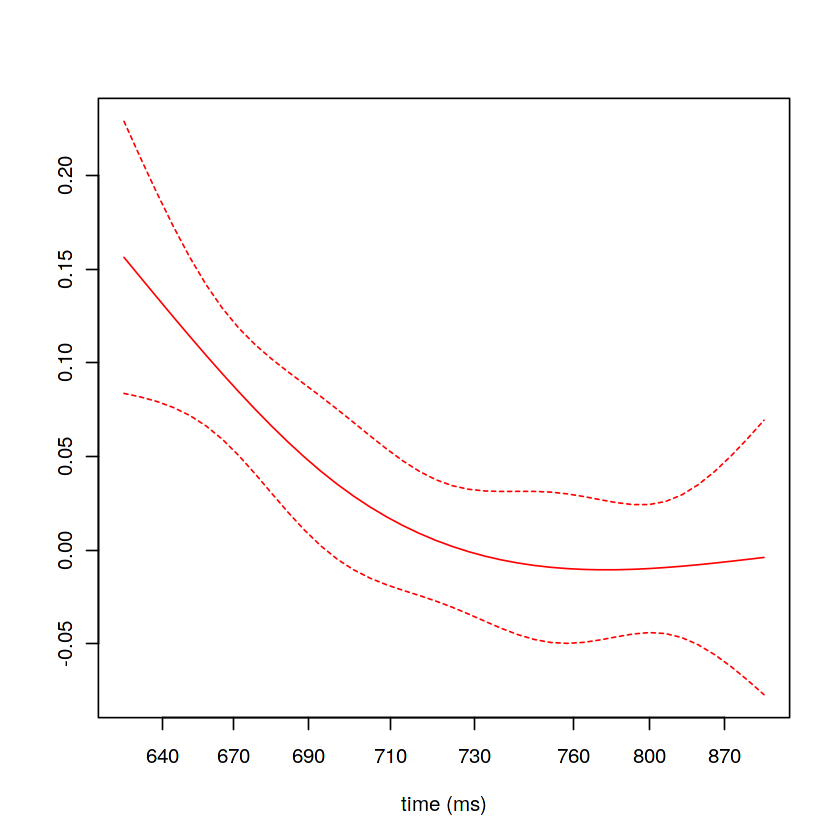

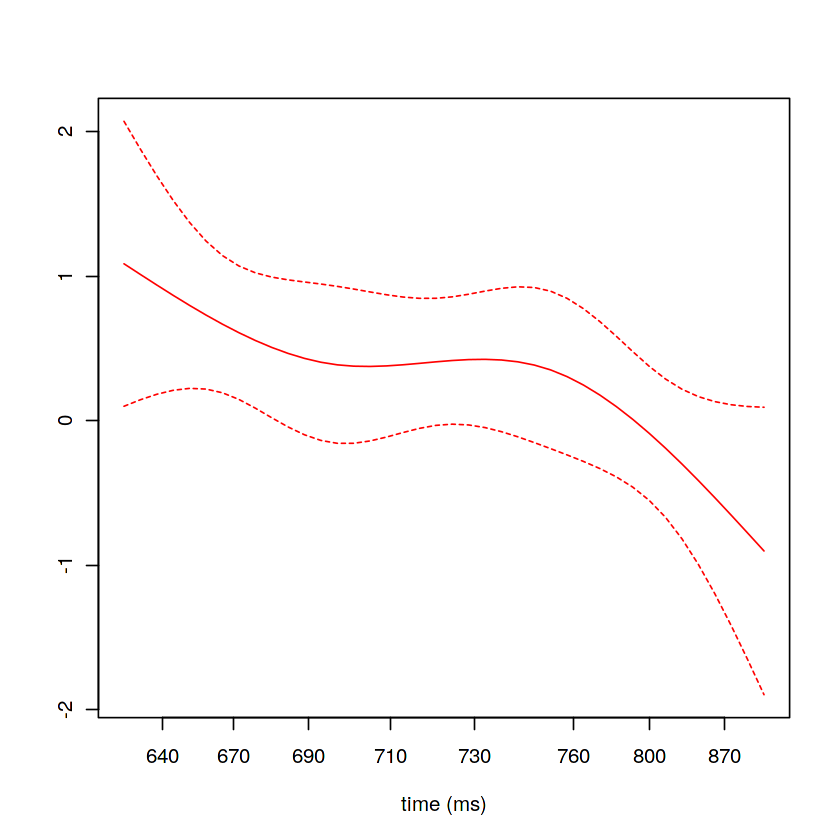

In [41]:
# Schoenfeld residuals plot
plot(cox.zph.mult, resid = FALSE, xlab = "time (ms)", ylab = "beta(t)", col = "red")

For none of the three predictors, the Schoenfeld residuals are constant over time. This contradicts the previous results of the statistical test that hazard rates are not constant over time for log.frequency only. Models like the Cox proportional hazards model can never perfectly and accurately capture the influence of each predictor. Rather, they provide estimates which can then be tested for goodness-of-fit. The Schoenfeld residuals plots provide evidence that the Cox proportional hazards model does not accurately capture the effect of the length, frequency, and orthographic neighbourhood of a verb in the past tense generation task.

### 7.2 Aalen additive hazards model
Again, the Aalen additive hazards model is an alternative to the Cox proportional hazards model. It does not assume  that hazard ratios are constant over time and thus allows to find out whether predictor effects vary over time.

In [42]:
# fit Aalen additive hazards model to the data
aareg.mult = aareg(Surv(rt,status) ~ length + log.frequency + log.old20, data = vb)
# show summary
aareg.mult

Call:
aareg(formula = Surv(rt, status) ~ length + log.frequency + log.old20, 
    data = vb)

  n= 1978 
    341 out of 349 unique event times used

                  slope      coef se(coef)      z        p
Intercept      9.84e-04  8.47e-04 1.10e-04  7.690 1.42e-14
length        -5.74e-05 -2.11e-05 2.56e-05 -0.822 4.11e-01
log.frequency  8.59e-05  3.00e-05 1.05e-05  2.860 4.27e-03
log.old20      7.81e-04  3.05e-04 1.43e-04  2.130 3.33e-02

Chisq=11.33 on 3 df, p=0.01; test weights=aalen

The *p*-value of 0.01 for the model as a whole suggests that the null hypothesis can be rejected. At least one of the predictors word length, word frequency, and orthographic neighbourhood influences the shape of the hazard function. The *p*-value for log.frequency (0.00427) and log.old20 (0.0333) are both small, for word length (0.411) it is too high to reject the null hypothesis. Consistent with the initial results of the Cox proportional hazards model for multiple predictors, the Aalen additive hazards model indicates that word frequency and orthographic neighbourhood have a significant effect on the shape of the hazard function, whereas word length does not. The effect of word frequency is a bit smaller than the effect of old20. The positive slope values of log.frequency and log.old20 indicate that hazard rates are higher for high frequency verbs and verbs with few orthographic neighbours. To find out whether the effects of word length, word frequency, and old20 vary as a function of time, we plot the results of the Aalen additive hazards model.

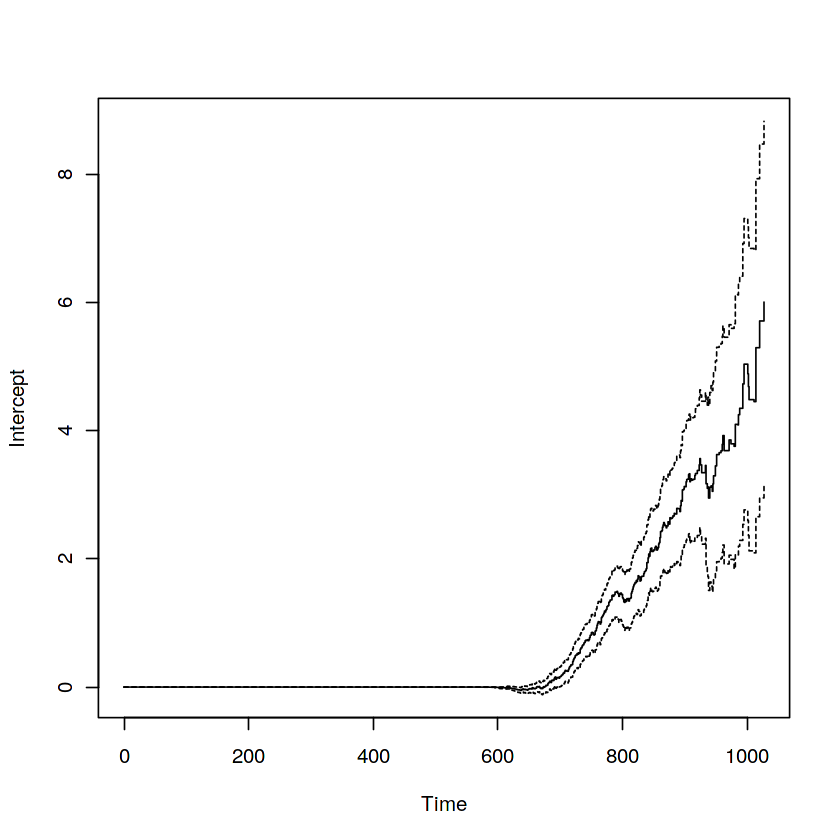

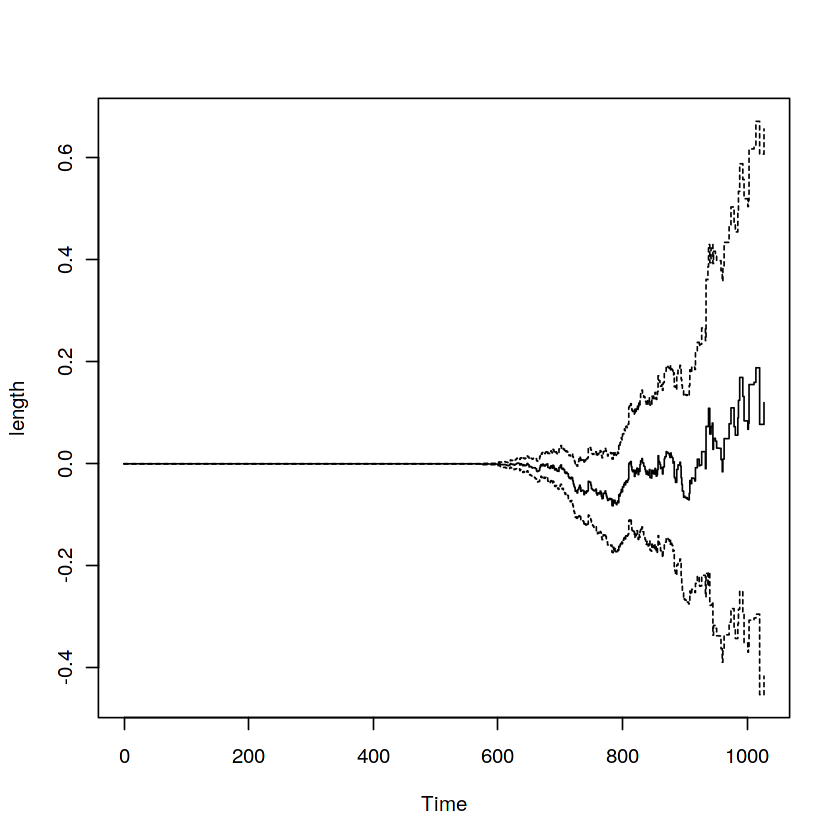

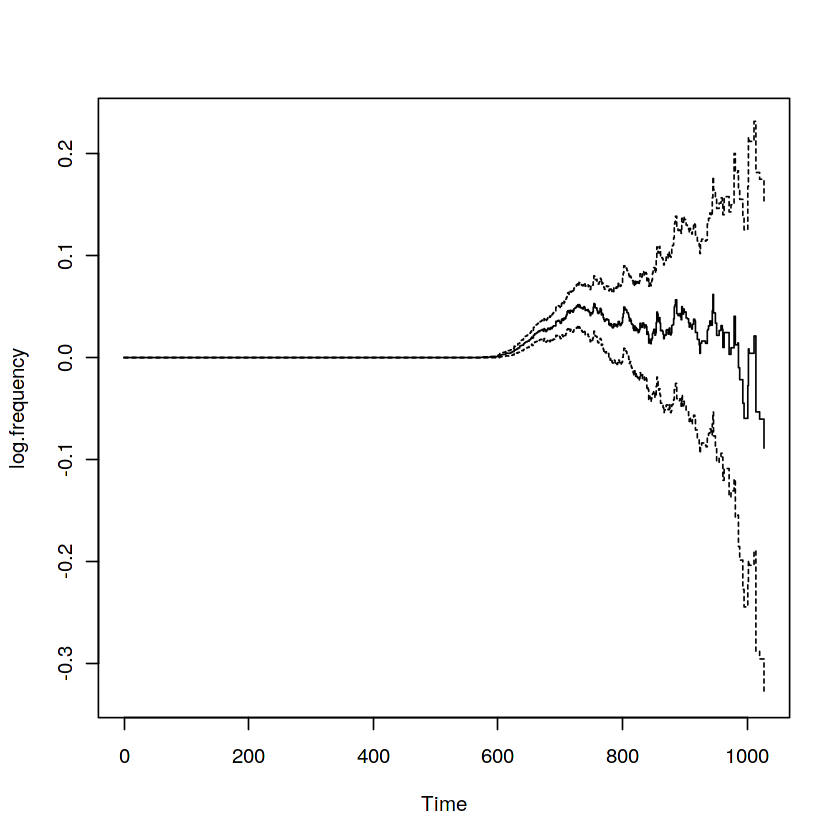

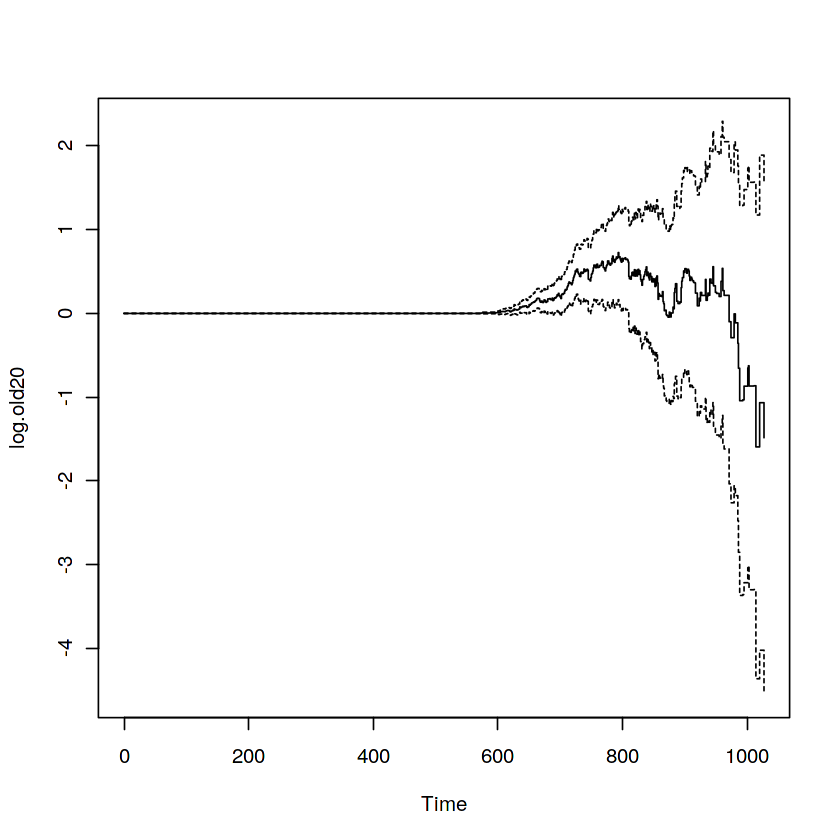

In [43]:
# cumulative hazard plots
plot(aareg.mult)

The first plot represents the baseline cumulative hazard, which steadily increases over time. This indicates that at each point in time the probability of a response, given that no response was registered prior to that point in time, is greater than 0. The cumulative coefficient for word length decreases until about 800 ms and then increases slightly with occasional declines. Hence, the effect of word length shows temporal changes. In early stages of the response time window, hazard rates are lower for longer words. However, in later stages, hazard rates are higher for longer words. Consequently, longer words are unlikely to be responded to early on, probably because of the increased visual information that has to be processed. Once this information has been processed, however, the increased amount of information in longer words seems to make it easier to recognize these words and prepare the appropriate response.<br>
Such temporal changes are also evident in the cumulative hazard curves for log.frequency and log.old20. They both rise initially and then decrease and oscillate substantially from approximately 900 ms to the end of the time window. However, it is harder to theoretically interpret the changes for word frequency and orthographic neighbourhood. The respective other predictors might play a role in the effect. For instance, low frequency words are usually also longer on average and therefore more likely to be responded at later stages of the time window.
## 8. Summary
The main results that the time-to-event analysis of past tense generation data yields are the following:
* Regularity is the predictor with principal effect on response time. Regular verbs are on average responded to earlier than irregular verbs (they have lower survival probability and higher hazard rates). This is not surprising given the higher processing effort of irregular verb inflection.
* Word length does not have a significant effect on hazard rates.
* Word frequency, semantic neighbourhood and orthographic neighbourhood all have a small effect on hazard rates. On average, hazard rates are higher for frequent verbs with many semantic and few orthographic neighbours. They tend to get responded to earlier.
* However, all predictor effects vary over time.
<br>
<br>

#### References

Cohen-Shikora, E. R., Balota, D. A., Kapuria, A., & Yap, M. J. (2013). The past tense inflection project (PTIP): Speeded past tense inflections, imageability ratings, and past tense consistency measures for 2,200 verbs. Behavior Research Methods, 45(1), 151-159.

Hendrix, P. (Winter Semester 2019/20). Time-to-event Analysis of Linguistic Data [University Course and Course Material].